**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex

In [2]:
cplex.__path__  # make sure the path is the one we pick above

['/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx/cplex']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

In [4]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m15-improved.csv'
path_dump_improved = '../output/m16-improved.csv' # lowest cost

num_cpu_cores = 6
#time_limit = -1 # unlimited
time_limit = 8*60*60  # in s

max_family_rank = 11  # maximum number of rank of the preference days for each family
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     70901.16843914894
Preference cost: 65596
Accounting cost: 5305.168439148937


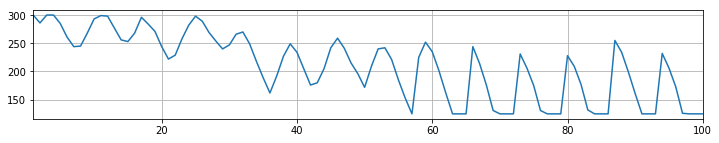

In [7]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy); plt.xlim(1, N_days); plt.grid(); plt.show()

In [8]:
accounting_cost_per_day = [
    nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
]

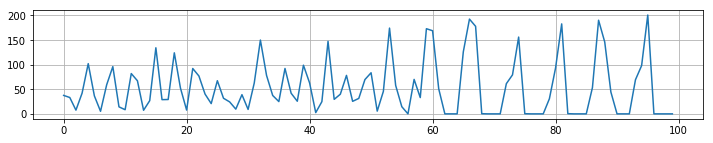

In [9]:
plt.figure(figsize=(12, 2))
plt.plot(accounting_cost_per_day); plt.grid(); plt.show()

### Family not on choice 0

In [10]:
print({c: (assigned_day == family_pref[:, c]).sum() for c in range(10)})

{0: 3961, 1: 791, 2: 203, 3: 43, 4: 2, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


### Test modify

In [11]:
occupancy[50], occupancy[55]

(172, 185)

In [12]:
occupancy[50] = occupancy[50] + 2
occupancy[55] = occupancy[55] - 2

## CPLEX MIP

In [13]:
from docplex.mp.model import Model

In [14]:
solver = Model('')

In [15]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 6
Num treads: threads:int(6)
Set time limit: None


In [ ]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

In [16]:
families = range(N_families)
days = range(1, N_days + 1)

In [17]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 11


In [18]:
family_id_choice_to_pref_cost

array([[   0,   50,   86, ...,  544, 1440, 2236],
       [   0,   50,   86, ...,  544, 1440, 2236],
       [   0,   50,   77, ...,  508, 1205, 1802],
       ...,
       [   0,   50,  104, ...,  616, 1910, 3104],
       [   0,   50,   95, ...,  580, 1675, 2670],
       [   0,   50,   86, ...,  544, 1440, 2236]])

## Variables

In [19]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [20]:
len(assignment_matrix)

55000

In [21]:
possible_family_sizes = np.unique(n_people)

In [22]:
# unpreferred_day_counts[day, size]
ub = int(N_max_people / possible_family_sizes.min())
unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')

In [23]:
len(unpreferred_day_counts)

700

In [24]:
unpreferred_day_counts[100, 8]

docplex.mp.Var(type=I,name='d_100_8',ub=150)

## Constraints

### constraint 1: each family only take one day (choice)

In [25]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_(
    [solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1
     for family in families],
    'family_ct'
)

### constraint 2: occupancy

In [26]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

10

In [27]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [28]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [29]:
# fixed occupancy
solver.add_constraints_([occupancy_counts[day] == occupancy[day] for day in days])

### constraint 3: unpreferred day family count conservation for each family size

In [30]:
# constraint 3: unpreferred day family count conservation for each family size

In [31]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [32]:
solver.add_constraints_(
    [
        solver.sum([assignment_matrix[family, N_choices - 1]
                   for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ],
    ['unpreferred_day_counts[%i]' % size for size in possible_family_sizes]
)

## Objective

In [33]:
# Objective - Preference cost only as approximation
solver.minimize(
    solver.sum([
        assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
        for family in families for c in range(N_choices)
    ])
)

xx = solver.constraints()[0]

[xx.GetCoefficient(assignment_matrix[1, c]) for c in range(N_choices)]

xx.name()

## Solve

In [34]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
solver.add_progress_listener(TextProgressListener(clock=ProgressClock.Objective, absdiff=200))

In [35]:
%%time
# Solve
sol = solver.solve()

  1+: Node=1558 Left=1 Best Integer=65651.0000, Best Bound=65639.4836, gap=0.02%, ItCnt=57133 [49.1s]
CPU times: user 3min 31s, sys: 2.81 s, total: 3min 33s
Wall time: 49.7 s


In [36]:
print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Solution status: JobSolveStatus.OPTIMAL_SOLUTION
Total cost: 65651 65651
Time: 49.636 s


In [37]:
# for k, v in sol.iter_var_values():
#     print(k, v)

In [38]:
# sol.get_value_dict(assignment_matrix, keep_zeros=False)

In [39]:
# sol.get_value_dict(unpreferred_day_counts)

## Get solution

In [40]:
assigned_day_new = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new[family] = family_pref[family, choice]

In [41]:
print('valid assigned_day:', (assigned_day_new >= 0).all())

valid assigned_day: True


In [42]:
unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)

In [43]:
# if N_choices >= N_choices_ori:
unpreferred_day_counts_sol = {
    size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
    for size in possible_family_sizes
}

print('Unpreferred families slots:')
{size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

Unpreferred families slots:


{2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}

In [44]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)

occupancy_new = assigned_day_to_occupancy(assigned_day_new)

deep_check(assigned_day_new, family_on_day_new, occupancy_new)

deep check: everything looks fine.


True

In [45]:
print('Total score:    ', cal_total(assigned_day_new, occupancy_new))
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

Total score:     70969.46706563326
Preference cost: 65651
Accounting cost: 5318.467065633259


In [46]:
occupancy_new

array([125, 300, 286, 300, 300, 285, 261, 244, 245, 268, 293, 299, 298,
       277, 256, 253, 268, 296, 284, 271, 244, 222, 229, 258, 282, 298,
       289, 269, 254, 240, 247, 266, 270, 249, 218, 189, 162, 192, 227,
       249, 234, 205, 176, 180, 205, 242, 259, 241, 215, 196, 174, 209,
       240, 242, 221, 183, 153, 125, 225, 252, 235, 201, 162, 125, 125,
       125, 244, 214, 176, 131, 125, 125, 125, 231, 206, 175, 131, 125,
       125, 125, 228, 209, 177, 132, 125, 125, 125, 255, 234, 199, 161,
       125, 125, 125, 232, 206, 173, 126, 125, 125, 125, 125], dtype=int32)

## Output solution

In [44]:
dump_conf(assigned_day_new, path_dump_improved)

## Debug

In [45]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [46]:
# [
#     [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#     for day in range(1, 10)
# ]        